In [4]:
pip install numpy pandas scikit-learn matplotlib nltk pyprind

Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
import sys
import tarfile
import time
import urllib.request

source = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
target = 'aclImdb_v1.tar.gz'

def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    if duration == 0:  # prevent division by zero
        duration = 1e-6
    progress_size = int(count * block_size)
    if total_size > 0:
        percent = count * block_size * 100.0 / total_size
    else:
        percent = 0
    speed = progress_size / (1024.0**2 * duration)
    sys.stdout.write("\r%d%% | %d MB | %.2f MB/s | %d sec elapsed" %
                     (percent, progress_size / (1024.0**2), speed, duration))
    sys.stdout.flush()

# Download only if not already downloaded or extracted
if not os.path.isdir('aclImdb'):
    print("Downloading IMDB dataset...")
    urllib.request.urlretrieve(source, target, reporthook)
    print("\nDownload complete. Extracting files...")

    with tarfile.open(target, 'r:gz') as tar:
        tar.extractall()
    print("Extraction complete!")
else:
    print("Dataset already exists. Skipping download.")


100% | 80 MB | 0.12 MB/s | 693 sec elapsed
Download complete. Extracting files...


C:\Users\matsh\AppData\Local\Temp\ipykernel_31100\2852221307.py:35: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Extraction complete!


In [1]:
import os
import pandas as pd
import pyprind

basepath = 'aclImdb'
labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
data = []  # store all reviews here

for s in ('train', 'test'):
    for label in ('pos', 'neg'):
        path = os.path.join(basepath, s, label)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
                data.append([txt, labels[label]])  # add row
                pbar.update()

# Convert once at the end — faster and clean
df = pd.DataFrame(data, columns=['review', 'sentiment'])
df.to_csv('movie_data.csv', index=False, encoding='utf-8')

print("Saved to movie_data.csv")

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:19:03


Saved to movie_data.csv


In [83]:
import re

def preprocessor(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]*>', '', text)
    # Find emoticons
    emoticons = re.findall(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove non-word characters and add emoticons at the end
    text = re.sub(r'[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    return text

df['review'] = df['review'].apply(preprocessor)

In [84]:
#Part2

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

count = CountVectorizer()
docs = np.array([
    'The sun is shining',
    'The weather is sweet',
    'The sun is shining and the weather is sweet'
])
bag = count.fit_transform(docs)
print(count.vocabulary_)
print(bag.toarray())

{'the': 5, 'sun': 3, 'is': 1, 'shining': 2, 'weather': 6, 'sweet': 4, 'and': 0}
[[0 1 1 1 0 1 0]
 [0 1 0 0 1 1 1]
 [1 2 1 1 1 2 1]]


In [85]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
print(tfidf.fit_transform(bag).toarray())

[[0.         0.43370786 0.55847784 0.55847784 0.         0.43370786
  0.        ]
 [0.         0.43370786 0.         0.         0.55847784 0.43370786
  0.55847784]
 [0.40474829 0.47810172 0.30782151 0.30782151 0.30782151 0.47810172
  0.30782151]]


In [86]:
#Part3
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')

def tokenizer(text):
    return text.split()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)

param_grid = [{
    'vect__ngram_range': [(1, 1)],
    'vect__stop_words': [stop, None],
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [1.0, 10.0]
}]

lr_tfidf = Pipeline([
    ('vect', tfidf),
    ('clf', LogisticRegression(random_state=0, solver='liblinear'))
])


X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, scoring='accuracy', cv=5, verbose=1)
gs_lr_tfidf.fit(X_train, y_train)
print('Best Accuracy: %.3f' % gs_lr_tfidf.best_score_)
print('Best Params:', gs_lr_tfidf.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Accuracy: 0.867
Best Params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'vect__ngram_range': (1, 1), 'vect__stop_words': None}


In [88]:
#Part 4
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv)
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y


In [89]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import HashingVectorizer
import numpy as np

vect = HashingVectorizer(decode_error='ignore', n_features=2**21, preprocessor=None, tokenizer=tokenizer)
clf = SGDClassifier(loss='log_loss', random_state=1, max_iter=1)
doc_stream = stream_docs(path='movie_data.csv')

classes = np.array([0, 1])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)

In [90]:
vfrom sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

df = pd.read_csv('movie_data.csv', encoding='utf-8')

count = CountVectorizer(stop_words='english', max_df=.1, max_features=5000)
X = count.fit_transform(df['review'].values)

lda = LatentDirichletAllocation(n_components=10, random_state=123, learning_method='batch')
X_topics = lda.fit_transform(X)

n_top_words = 5
feature_names = count.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic 1:
worst minutes script awful stupid
Topic 2:
family mother father children girl
Topic 3:
american dvd music tv war
Topic 4:
human audience cinema art sense
Topic 5:
police guy car dead murder
Topic 6:
horror house sex gore blood
Topic 7:
role performance comedy actor performances
Topic 8:
series war episode episodes season
Topic 9:
book version original effects fi
Topic 10:
action fight guy guys cool


In [96]:

!pip install wordcloud

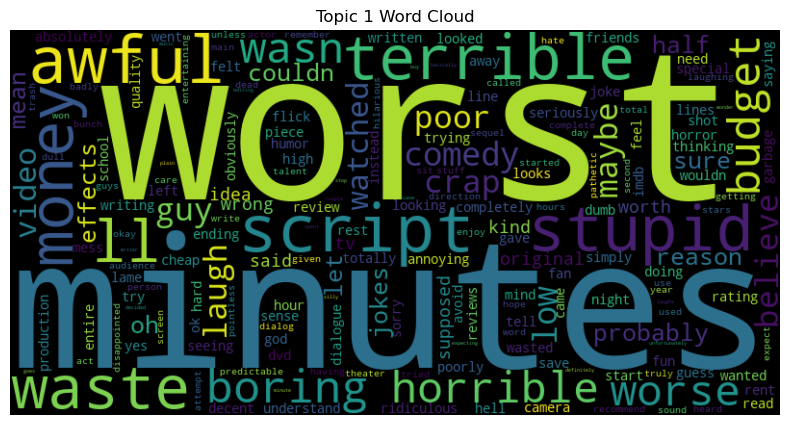

In [104]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Example: Word cloud for topic 0
topic_words = {feature_names[i]: lda.components_[0][i] for i in range(len(feature_names))}
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(topic_words)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Topic 1 Word Cloud")
plt.savefig("tfidf_top_words.png", dpi=300, bbox_inches='tight')
plt.show()

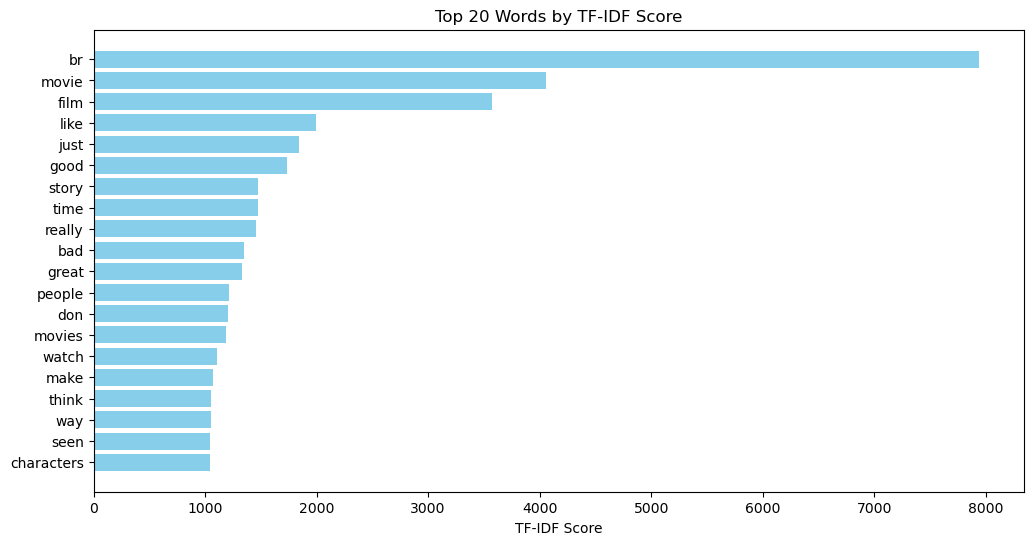

In [106]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf.fit_transform(df['review'].values)

# Sum TF-IDF scores for each word
tfidf_sum = np.array(X_tfidf.sum(axis=0)).flatten()
words = np.array(tfidf.get_feature_names_out())

# Top 20 words
top_n = 20
top_indices = tfidf_sum.argsort()[-top_n:][::-1]
top_words = words[top_indices]
top_scores = tfidf_sum[top_indices]

# Plot
plt.figure(figsize=(12,6))
plt.barh(top_words[::-1], top_scores[::-1], color='skyblue')
plt.xlabel("TF-IDF Score")
plt.title("Top 20 Words by TF-IDF Score")
plt.savefig("lda_topic1.png", dpi=300, bbox_inches='tight')
plt.show()
